#**Enron Email NLP Analysis: Feature Extraction & Classification**

## Objective:
Analyze a subset of Enron emails to extract features and build a simple NLP pipeline using Python for the following tasks:

*   Text preprocessing
*   Feature extraction
*   Logistic regression classification
*   Interpret and explain results



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset shape: (2500, 2)
                  filename                                               text
0    allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1   allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2  allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
(2477, 4)
                    sender                 receiver   subject  \
0  phillip.allen@enron.com     tim.belden@enron.com             
1  phillip.allen@enron.com  john.lavorato@enron.com       Re:   
2  phillip.allen@enron.com   leah.arsdall@enron.com  Re: test   

                                         body_tokens  
0                                         [forecast]  
1  [traveling, business, meeting, take, fun, trip...  
2                            [test, successful, way]  
Feature matrix shape: (2477, 5000)
Example features: ['aaiis' 'abb' 'ability' 'able' 'abn' 'abroad' 'absence' 'absolutely'
 'absorbed' 'abundant']


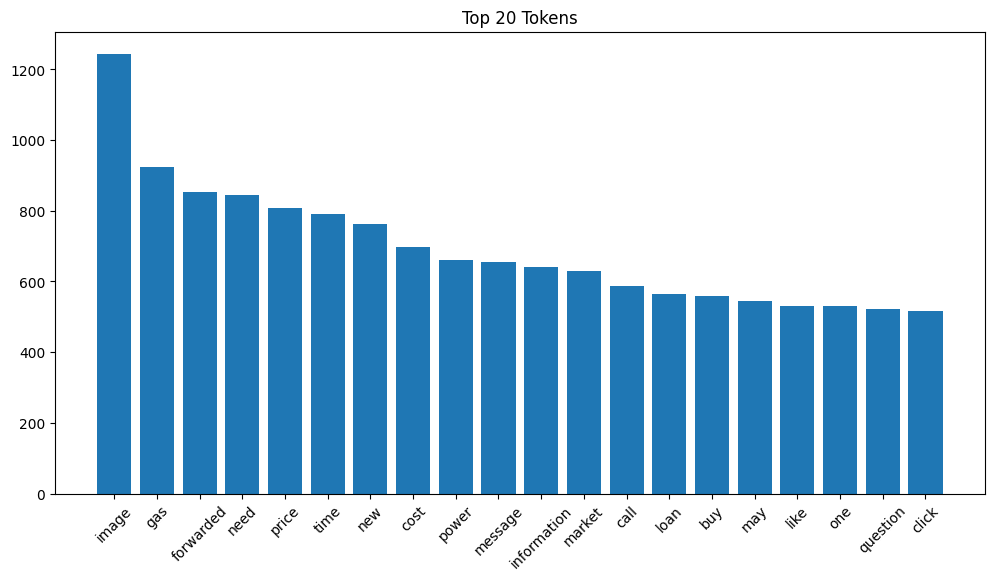

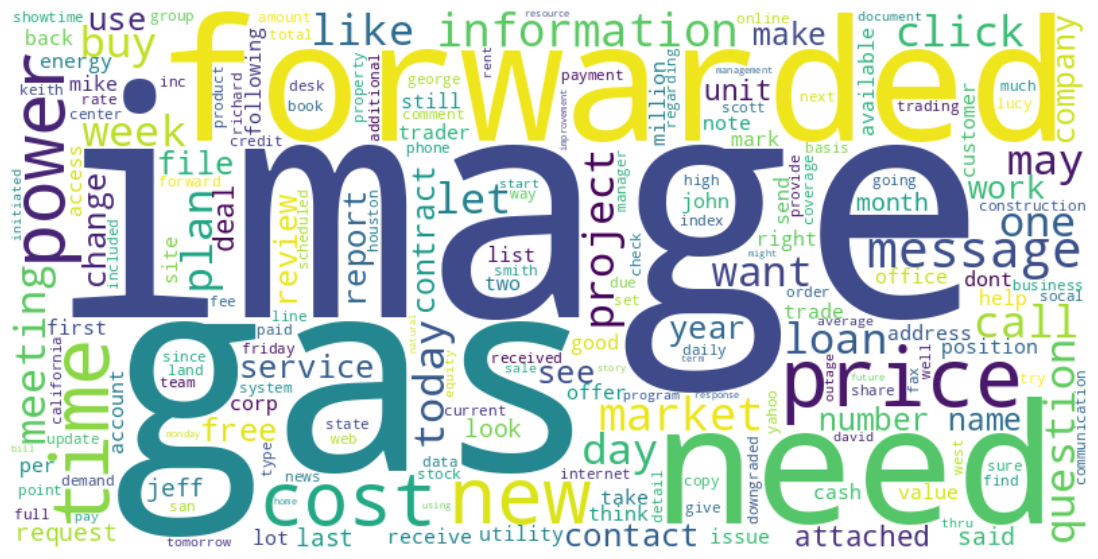

                                           body_text  label
0                                           forecast      2
1  traveling business meeting take fun trip espec...      0
2                                test successful way      0
3  randy send schedule salary level everyone sche...      0
4                                  let shoot tuesday      0
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       392
           1       0.92      0.90      0.91        39
           2       1.00      0.75      0.86        20
           3       0.88      0.71      0.79        31
           4       0.77      0.71      0.74        14

    accuracy                           0.94       496
   macro avg       0.90      0.81      0.85       496
weighted avg       0.94      0.94      0.94       496

Confusion Matrix:

[[385   2   0   2   3]
 [  3  35   0   1   0]
 [  4   1  15   0   0]
 [  9   0   0  22   0]
 [  4   0   0   

In [129]:
# -----------------------------
# 1. Imports & Setup
# -----------------------------

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords
stop_words = set(stopwords.words('english'))
# Custom email-specific stopwords
email_stopwords = {
    'subject', 're', 'email', 'pm', 'cc', 'bcc', 'http', 'https', 'com', 'enron', 'thanks', 'thank', 'regards', 'please',
    'would', 'could', 'also', 'get', 'us', 'know', 'hi', 'hello', 'dear',
    'sent', 'from', 'to', 'on', 'at', 'am', 'x', 'mime', 'content', 'charset',
    'date', 'messageid', 'original', 'allenhouect', 'phillip', 'allen',
    'tim', 'belden', 'pallen'
}
stop_words.update(email_stopwords)


# -----------------------------
# 2. Helper Functions
# -----------------------------

def is_valid_token(token, min_len=3):
    """Filter tokens: min length, no digits or digit-containing tokens."""
    if len(token) < min_len:
        return False
    if token.isdigit():
        return False
    if re.search(r'\d', token):
        return False
    return True

def preprocess_email(raw_email):
    """
    Extract sender, receiver, subject, and clean body tokens from raw email text.
    Returns a dict with keys: sender, receiver, subject, body_tokens
    """
    email_data = {'sender': None, 'receiver': None, 'subject': None, 'body_tokens': []}
    lines = raw_email.splitlines()
    body_lines = []

    for line in lines:
        line = line.strip()
        lower_line = line.lower()

        # Extract headers
        if lower_line.startswith('from:'):
            email_data['sender'] = line[5:].strip()
            continue
        if lower_line.startswith('to:'):
            email_data['receiver'] = line[3:].strip()
            continue
        if lower_line.startswith('subject:'):
            email_data['subject'] = line[8:].strip()
            continue

        # Skip meta headers
        if re.match(r'^(x-|mime-|content-|charset|date|messageid|original|sent|from|to|cc|bcc|reply-to)', lower_line):
            continue

        # Accumulate body
        body_lines.append(line)

    # Clean body text
    body_text = " ".join(body_lines).lower()
    body_text = re.sub(r'\S+@\S+', 'EMAIL', body_text)
    body_text = re.sub(r'http\S+', '', body_text)
    body_text = re.sub(r'[^a-z0-9\s]', '', body_text)

    # Tokenize, lemmatize, filter stopwords & invalid tokens
    tokens = [
        lemmatizer.lemmatize(word)
        for word in body_text.split()
        if word not in stop_words and is_valid_token(word)
    ]
    email_data['body_tokens'] = tokens

    return email_data


def extract_features(df, column='body_tokens', method='count', max_features=5000):
    """
    Converts preprocessed email text into a feature matrix.
    Returns X_features, feature_names, vectorizer
    """
    # Join tokens back into string
    df['body_text'] = df[column].apply(lambda tokens: ' '.join(tokens))

    if method == 'count':
        vectorizer = CountVectorizer(max_features=max_features)
    elif method == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features)
    else:
        raise ValueError("method must be 'count' or 'tfidf'")

    X_features = vectorizer.fit_transform(df['body_text'])
    feature_names = vectorizer.get_feature_names_out()

    print(f"Feature matrix shape: {X_features.shape}")
    print(f"Example features: {feature_names[:10]}")

    return X_features, feature_names, vectorizer


def assign_label(text):
    """
    Rule-based labeling:
    0: Routine / low priority
    1: Legal / compliance
    2: Financial risk
    3: Executive decision
    4: External communication
    Defaults to 0 if no keywords match.
    """
    label_keywords = {
        0: ['lunch', 'birthday', 'meeting', 'fyi', 'note'],
        1: ['contract', 'regulation', 'policy', 'legal', 'compliance'],
        2: ['invoice', 'payment', 'budget', 'forecast', 'audit'],
        3: ['approval', 'decision', 'strategy', 'board', 'directive'],
        4: ['client', 'partner', 'vendor', 'external', 'outreach', 'collaborate']
    }

    text = text.lower()
    for label, keywords in label_keywords.items():
        if any(word in text for word in keywords):
            return label
    return 0


def visualize_tokens(df, top_n=20):
    """Show bar chart and word cloud of top tokens."""
    all_tokens = [token for tokens in df['body_tokens'] for token in tokens]
    token_counts = Counter(all_tokens)
    top_tokens = token_counts.most_common(top_n)
    words, counts = zip(*top_tokens)

    # Bar chart
    plt.figure(figsize=(12,6))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} Tokens")
    plt.show()

    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_counts)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


# -----------------------------
# 3. Load Dataset
# -----------------------------

# Example: load top 2500 rows for demo
df = pd.read_csv("/kaggle/input/enron-email-dataset/emails.csv").head(2500)
df.columns = ['filename', 'text']

print(f"Dataset shape: {df.shape}")
print(df.head(3))


# -----------------------------
# 4. Preprocess Emails
# -----------------------------

processed_emails = df['text'].apply(preprocess_email)
processed_df = pd.DataFrame(list(processed_emails))

# Remove emails with empty body_tokens
df_clean = processed_df[processed_df['body_tokens'].map(len) > 0].reset_index(drop=True)
print(df_clean.shape)
print(df_clean.head(3))


# -----------------------------
# 5. Feature Extraction
# -----------------------------

X_features, feature_names, vectorizer = extract_features(df_clean, column='body_tokens', method='count')


# -----------------------------
# 6. Visualization
# -----------------------------

visualize_tokens(df_clean, top_n=20)


# -----------------------------
# 7. Rule-Based Labeling
# -----------------------------

df_clean['label'] = df_clean['body_text'].apply(assign_label)
print(df_clean[['body_text','label']].head(5))


# -----------------------------
# 8. Train-Test Split & Logistic Regression
# -----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_features, df_clean['label'], test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


##Summary and Next Steps

**Current NLP Pipeline Summary:**

*   Emails were preprocessed: headers removed, body cleaned, emails and URLs replaced/removed.
*   Tokens were lowercased, lemmatized (instead of stemmed) to preserve word meaning, filtered for stopwords, and tokens with fewer than 3 characters were removed.
*   Feature extraction was done using CountVectorizer (max 5000 features).
*   Top tokens were visualized with a bar chart and word cloud.
*   Rule-based labeling assigned emails to categories:

      0.   Routine / low priority
      1.   Legal / compliance
      2.   Financial risk
      3.   Executive decision
      4.   External communication

*   Logistic Regression was trained and evaluated on the dataset. Overall accuracy is ~93%, but recall varies across categories, with minority classes like External Communication being harder to capture.

<br>


**Next Steps / Suggestions for Improvement:**

* For stopwords and the visualizations, general email noise words (like “subject,” “re,” “email”) were filtered out to reduce noise, but key terms such as “forward” and “attachment” were kept to preserve signals for classification. This balances interpretability in visualizations with maintaining features that help model performance.

* Experiment with TF-IDF instead of raw counts to capture more meaningful word importance.

* Fine-tune stopwords or add domain-specific stopwords to reduce noise.

* Explore oversampling/undersampling if class imbalance affects minority categories.

* Try multi-class models or Naive Bayes (as planned for Module 2).

* Consider n-grams (bigrams/trigrams) to capture common phrases in emails.

* Evaluate using cross-validation to better estimate model performance.